In [1]:
import itertools
from copy import deepcopy as copy

# from netgraph import InteactiveGraph # pip install netgraph
from functools import reduce
from itertools import chain, permutations, product
from operator import itemgetter
from time import time

import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
from numpy.linalg import matrix_rank as rank
from scipy.linalg import block_diag, fractional_matrix_power
from scipy.sparse import coo_array, csr_array

from utils.Adversary import Adversary
from utils.Conversions import hamming_dist as dist
from utils.Conversions import (
    mask_maker,
    partial,
    to_adversary_mat,
    to_str,
    to_str_list,
    visualize,
)
from utils.Problems import ED, Problem, exact_k, threshold_k
from utils.Solvers import (
    adv_solver,
    instance_mask,
    ket,
    relative_hadamard_norm_max,
    type_mask,
)

mpl.rcParams["figure.dpi"] = 120
from multiprocessing.pool import ThreadPool as Pool

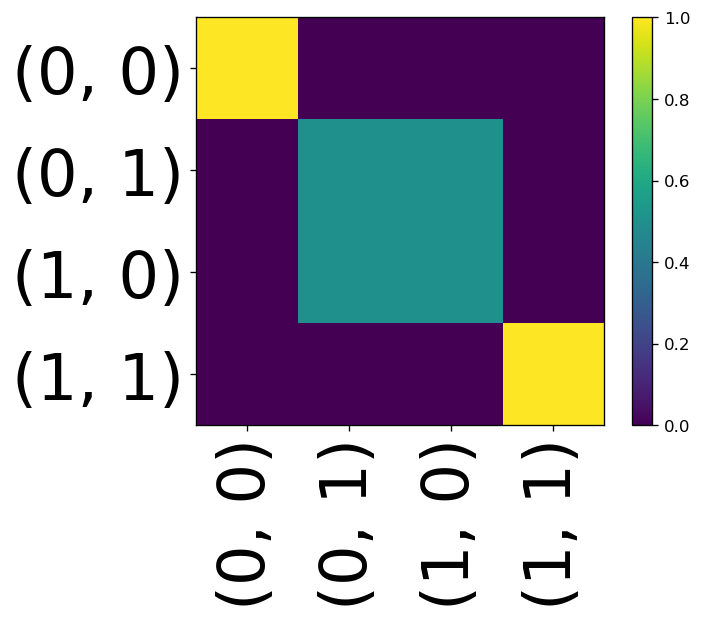

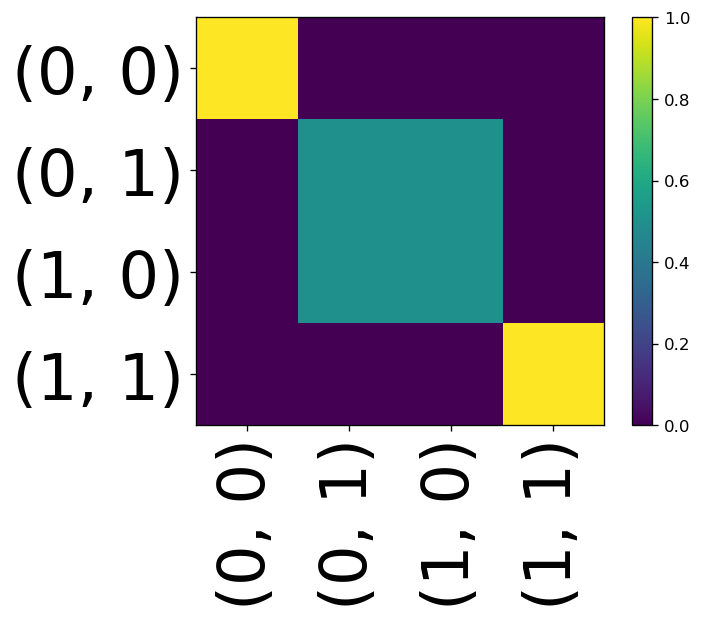

In [2]:
def get_instance_delta(x, y):
    n = len(x)
    mat = np.zeros((n, n))
    for i, (a, b) in enumerate(zip(x, y)):
        if a != b:
            mat[i, i] = 1
    return mat

def get_deltas(problem):
    return {(no, yes): np.kron(instance_mask(problem, no, yes), get_instance_delta(no, yes)) for no, yes in product(problem.no_instances, problem.yes_instances)}

def get_delta(prob):
    no_zero_size = prob.no_len * prob.n
    yes_zero_size = prob.yes_len * prob.n
    labels = to_str_list(list(itertools.product((prob.instances), range(n))))
    instance_mats = []
    for no in prob.no_instances:
        instance_mats.append([])
        no_i = prob.instance_to_index[no]
        for yes in prob.yes_instances:
            yes_i = prob.instance_to_index[yes]
            instance_mats[-1].append(get_instance_delta(no, yes))
    instance_mats = np.block(instance_mats)
    mat = np.block(
        [
            [np.zeros((no_zero_size, no_zero_size)), instance_mats],
            [instance_mats.T, np.zeros((yes_zero_size, yes_zero_size))],
        ]
    )
    return mat, labels


def get_Dz(prob, instance):
    instance_mat = np.zeros((prob.len, prob.len))
    i = prob.instance_to_index[instance]
    instance_mat[i, i] = 1
    return np.kron(instance_mat, np.eye(prob.n))


def vec(A):
    m, n = A.shape[0], A.shape[1]
    return A.reshape(m * n, order="F")


def commutation_matrix_sp(A):
    m, n = A.shape[0], A.shape[1]
    row = np.arange(m * n)
    col = row.reshape((m, n), order="F").ravel()
    data = np.ones(m * n, dtype=np.int8)
    K = csr_matrix((data, (row, col)), shape=(m * n, m * n))
    return K


# (i, j) -> (j, i)
def transpose_mat(size):
    trans = np.zeros((size**2, size**2))
    for i in range(size):
        for j in range(size):
            row = size * i + j
            col = size * j + i
            trans[row, col] = 1

    return trans


def partial_transpose_fast(size):
    print("size", size)
    small_size = int(np.sqrt(size))
    assert small_size**2 == size
    print("small size", small_size)
    I = coo_array(np.eye(small_size))
    print(I)
    T = coo_array(transpose_mat(small_size))
    partial_T_vec = scipy.sparse.kron(coo_array(np.eye(size)), T)
    conv = scipy.sparse.kron(I, scipy.sparse.kron(T, I))
    pt = conv @ partial_T_vec @ conv
    print(pt.shape, T.shape)
    return pt
    # for i in range(small)


def partial_transpose(mat, dim1=None, dim2=None, NP=False):
    assert mat.shape[0] == mat.shape[1]
    mat_size = mat.shape[0]
    if dim1 is None:
        size = int(np.sqrt(mat_size))
        dim1 = size
        dim2 = size
    elif dim2 is None:
        dim2 = mat_size // dim1
    print("dima=", dim1, dim2)

    assert dim2 * dim1 == mat_size, (
        "dim1=" + str(dim1) + ", dim2=" + str(dim2) + ", mat_size=" + str(mat_size)
    )

    pt_mat = cp.bmat(
        [
            [
                mat[i * dim2 : (i + 1) * dim2, j * dim2 : (j + 1) * dim2]
                for i in range(dim1)
            ]
            for j in range(dim1)
        ]
    )

    if NP:
        pt_mat = [
            [
                mat[i * dim2 : (i + 1) * dim2, j * dim2 : (j + 1) * dim2]
                for i in range(dim1)
            ]
            for j in range(dim1)
        ]

        print(pt_mat)
        pt_mat = np.block(pt_mat)
    return pt_mat

def symmetry_projection2(size):
    return (np.eye(size**2) + get_swap_mat2(size))/2
    
def symmetry_projection(pairs):
    if isinstance(pairs, int):
        part_size = int(np.sqrt(pairs))
        assert part_size**2 == pairs
        pairs = list(product(range(part_size), range(part_size)))
    proj = np.zeros((len(pairs), len(pairs)))
    inv_pairs = inv_map(pairs)
    for pair in pairs:
        pair_i = inv_pairs[pair]
        pair_rev = pair[::-1]
        pair_rev_i = inv_pairs[pair_rev]
        if not (pair == pair_rev and pair[0] != pair[1]):
            proj[pair_i, pair_rev_i] = 1
    return np.eye(len(pairs)) / 2 + proj / 2

 

def get_swap_mat2(part_size):
    swap = np.zeros((part_size**2, part_size**2))
    for i in range(part_size): 
        for j in range(part_size):
            ij = np.kron(ket(i, part_size), ket(j, part_size))
            ji = np.kron(ket(j, part_size), ket(i, part_size))
            swap += np.outer(ij,ji)
    return swap
    
def get_swap_mat(pairs):
    if isinstance(pairs, int):
        part_size = int(np.sqrt(pairs))
        assert part_size**2 == pairs
        pairs = list(product(range(part_size), range(part_size)))

    return 2 * symmetry_projection(pairs) - np.eye(len(pairs))

    

def inv_map(map):
    return {image: preimage for preimage, image in enumerate(map)}
n=2
labels = list(product(range(n), range(n)))
np.linalg.norm(symmetry_projection2(n)-symmetry_projection(n**2))
visualize(symmetry_projection2(n), (labels, labels))
visualize(symmetry_projection(n**2), (labels, labels))

In [3]:
def get_delta_constraint_mats(problem, rank):
    num_pairs = 2 * problem.no_len * problem.yes_len
    deltas = dict()
    delta, labels = get_delta(problem)
    proj = symmetry_projection((problem.len * rank * problem.n)**2)
    for (no, yes), curr_delta in get_deltas(problem).items(): 
        curr_delta = delta / num_pairs - curr_delta
        curr_delta = np.kron(curr_delta, np.eye(rank))
        curr_delta = np.kron(curr_delta, curr_delta)
        deltas[(no, yes)] = curr_delta
        print(np.linalg.norm(proj@curr_delta@proj))
    return deltas


def get_D_constraint_mats(problem, rank):
    D_mats = dict()
    for instance in problem.instances:
        curr_D = get_Dz(problem, instance) - np.eye(problem.len * problem.n) / prob.len
        curr_D = np.kron(curr_D, np.eye(rank))
        curr_D = np.kron(curr_D, curr_D)
        D_mats[instance] = curr_D
    return D_mats

def get_Ds(problem):
    return [get_Dz(problem, instance) for instance in problem.instances]
    
def space_adv_psd(problem, rank):
    num_pairs = 2*problem.no_len * problem.yes_len
    delta, labels = get_delta(problem)
    deltas = get_delta_constraint_mats(problem, rank)
    n = problem.n
    D_mats = get_D_constraint_mats(problem, rank)
    A = cp.Variable((problem.len, problem.len), symmetric=True)
    b = cp.Variable(problem.len)
    lam = cp.Variable()
    delta_to_sum = [
        A[problem.instance_to_index[no], problem.instance_to_index[yes]]
        * deltas[no, yes]
        for no, yes in product(problem.no_instances, problem.yes_instances)
    ]
    for pair, d in deltas.items():
        visualize(d, title=str(pair))
    
    delta_sum = cp.sum(delta_to_sum, axis=0)
    delta_sum = delta_sum + delta_sum.T
    D_mats = get_D_constraint_mats(problem, rank)
    D_to_sum = [
        b[problem.instance_to_index[instance]] * D_mats[instance]
        for instance in problem.instances
    ]
    D_sum = cp.sum(D_to_sum, axis=0)
    obj_mat = problem.len * delta / num_pairs
    obj_mat = np.kron(obj_mat, np.eye(rank))
    obj_mat = np.kron(obj_mat, obj_mat)
    M = (
        D_sum
        + delta_sum
         - obj_mat
    )
    M = lam * np.eye(delta_sum.shape[0]) + M
    vec_M = cp.vec(M)
    pt_mat = partial_transpose_fast(M.shape[0])
    proj = symmetry_projection(M.shape[0])
    constraints = [
        cp.multiply(A, type_mask(problem)) == A,
        proj @ M @ proj >> M,
        M >> 0,
    ]
    opt_prob = cp.Problem(cp.Minimize(lam), constraints)
    opt_prob.solve(solver="MOSEK", verbose=True)
    print(M.value)
    print("obj", opt_prob.value)
    return A.value, b.value, M.value, constraints

In [4]:
n = 3
prob = threshold_k(n, 1)

1.268383339647875
1.268383339647875
1.268383339647875


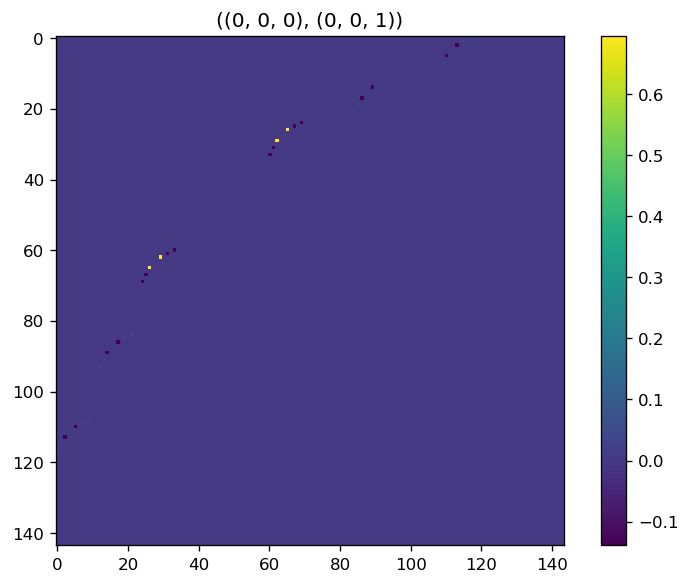

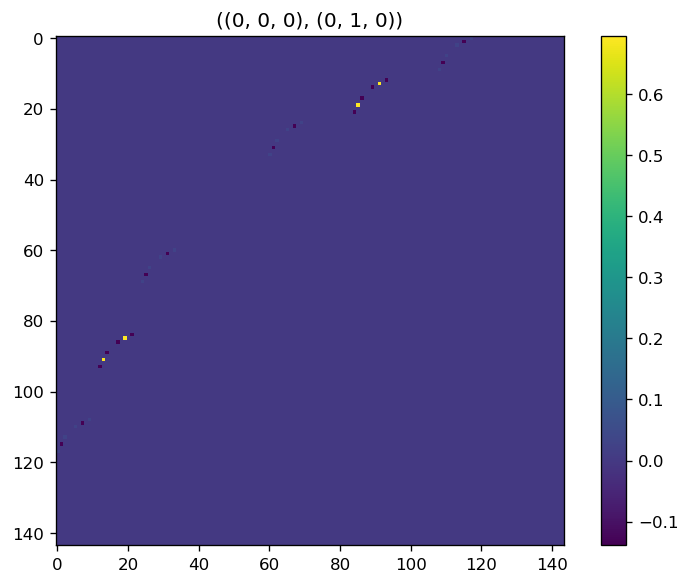

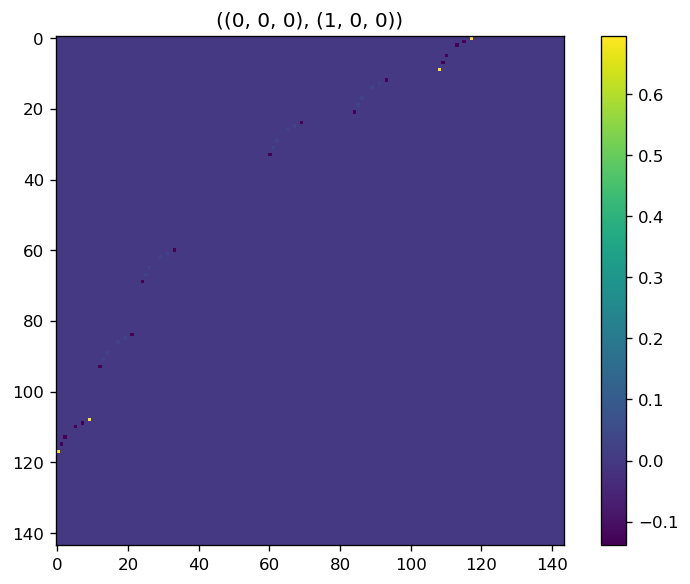

size 144
small size 12
<COOrdinate sparse array of dtype 'float64'
	with 12 stored elements and shape (12, 12)>
  Coords	Values
  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0
  (10, 10)	1.0
  (11, 11)	1.0
(20736, 20736) (144, 144)
                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Aug 20 09:15:07 AM: Your problem has 21 variables, 41488 constraints, and 0 parameters.
(CVXPY) Aug 20 09:15:07 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 20 09:15:07 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 20 09:15:07 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 20 09:15:07 AM: Your problem is compiled with the CPP canonicalization bac

In [5]:
rank = 1
A, b, M, constraints = space_adv_psd(prob, rank)
for c in constraints:
    print(c.dual_value)

In [6]:
def span_program_sep_psd(problem, rank):
    num_pairs = 2 * problem.no_len * problem.yes_len
    delta, labels = get_delta(problem)
    deltas = get_delta_constraint_mats(problem, rank)
    n = problem.n
    D_mats = get_D_constraint_mats(problem, rank)
    X_len = problem.len * n * rank
    X_len = X_len**2
    X = cp.Variable((X_len, X_len), PSD=True)
    proj = symmetry_projection(X.shape[0])
    constraints = [
        cp.trace(X) == 1,
        proj @ X @ proj == X,
    ]

    constraints += [
        cp.trace(M @ X) == 0 for M in list(deltas.values()) + list(D_mats.values())
    ]
    obj = (
        problem.len
        * cp.trace(np.kron(delta, np.eye(X.shape[0] // delta.shape[0])) @ X)
        / num_pairs
    )
    opt_prob = cp.Problem(cp.Maximize(obj), constraints)
    opt_prob.solve(solver="MOSEK", verbose=True)
    print("obj", opt_prob.value)
    return X.value

In [7]:
X = span_program_sep_psd(prob, rank)

1.268383339647875
1.268383339647875
1.268383339647875
                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Aug 20 09:15:09 AM: Your problem has 20736 variables, 20744 constraints, and 0 parameters.
(CVXPY) Aug 20 09:15:09 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 20 09:15:09 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 20 09:15:09 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 20 09:15:09 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug

In [8]:
class AdvBound():
    def __init__(self, problem, normalize=False, single_variable=False):
        self.problem = problem
        self.single_variable = single_variable
        self.normalize = normalize
        # Problem short-hand
        self.n = self.problem.n
        self.to_index = self.problem.instance_to_index
        
        # variables
        self.constraints = []
        self.constraint_mats = []

        self.set_variables()
        self.set_constraints()
        self.set_opt_prob()
        
    def set_variables(self):
        self.A = cp.Variable((self.problem.len, self.problem.len), symmetric=True)
        self.diag_weights = cp.Variable(self.problem.len)
    
    # constraint matrices
    def set_constraints(self):
        deltas = get_deltas(self.problem)
        Ds = get_Ds(self.problem)
        delta_combo = cp.sum([self.A[self.to_index[no], self.to_index[yes]] * delta for (no, yes), delta in deltas.items()], axis=0)
        delta_combo = delta_combo + delta_combo.T 
        D_combo = cp.sum([self.diag_weights[i] * Ds[i] for i in range(self.problem.len)], axis=0)
        self.constraints += [
            cp.sum(self.diag_weights) == 1,
            D_combo >> delta_combo
        
        ]
        self.constraint_mats += [delta_combo, D_combo]
            
    def set_opt_prob(self):     
        self.opt_prob = cp.Problem(cp.Maximize(cp.sum(cp.multiply(self.A, type_mask(self.problem)))), constraints=self.constraints)       
    
    def solve(self):
        self.opt_prob.solve("MOSEK", verbose=True)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Aug 20 09:08:42 AM: Your problem has 20 variables, 145 constraints, and 0 parameters.
(CVXPY) Aug 20 09:08:42 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 20 09:08:42 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 20 09:08:42 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 20 09:08:42 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 20 09:08:42 AM: Compiling problem (target solver=MOSEK).
(

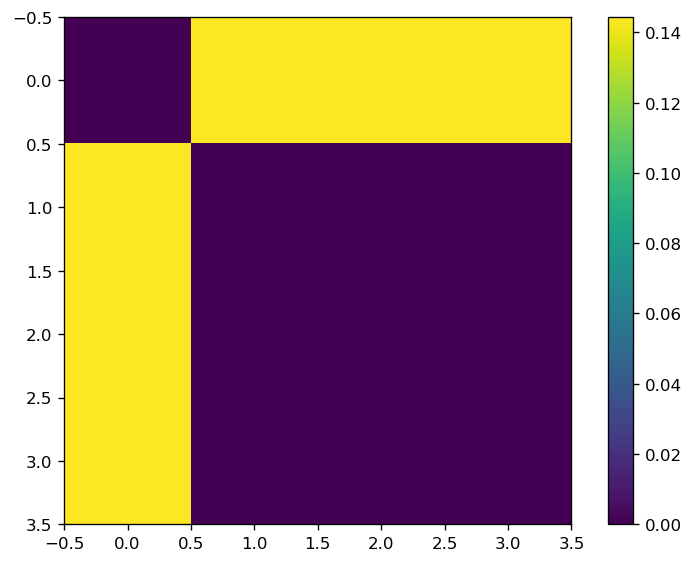

In [9]:
adv = AdvBound(prob)
adv.solve()
visualize(adv.A.value)

In [10]:
def span_bound(problem, single_variable=False, normalize=False):
    n = problem.n
    to_index = problem.instance_to_index

    var_size = problem.len * n
    X = cp.Variable((var_size, var_size), PSD=True)
    t = cp.Variable(nonneg=True)

    deltas = get_deltas(problem)
    Ds = get_Ds(problem)
    D_avg = np.sum(Ds, axis=0) / len(Ds)
    delta_avg = np.sum(list(deltas.values()), axis=0) / len(deltas)
    delta_eq = cp.trace(delta_avg@X) if normalize else 1
    constraints = []
    
    if normalize:
        # Ds = [D - D_avg for D in Ds]
        constraints += [cp.trace((D-np.eye(var_size)/problem.len)@X) == 0 for D in Ds]
        constraints += [cp.trace(X) == 1]
        obj = problem.len * cp.trace(delta_avg@X)
    else:
        constraints += [cp.trace(D@X) == t for D in Ds]
        obj = t
    constraints += [cp.trace(delta@X) == delta_eq for delta in deltas.values()]

    opt_prob = cp.Problem(cp.Maximize(obj) if normalize else cp.Minimize(obj), constraints=constraints)
    opt_prob.solve("MOSEK", verbose=True)

    return X.value, opt_prob.value

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Aug 20 09:08:45 AM: Your problem has 144 variables, 8 constraints, and 0 parameters.
(CVXPY) Aug 20 09:08:45 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 20 09:08:45 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 20 09:08:45 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 20 09:08:45 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 20 09:08:45 AM: Compiling problem (target solver=MOSEK).
(C

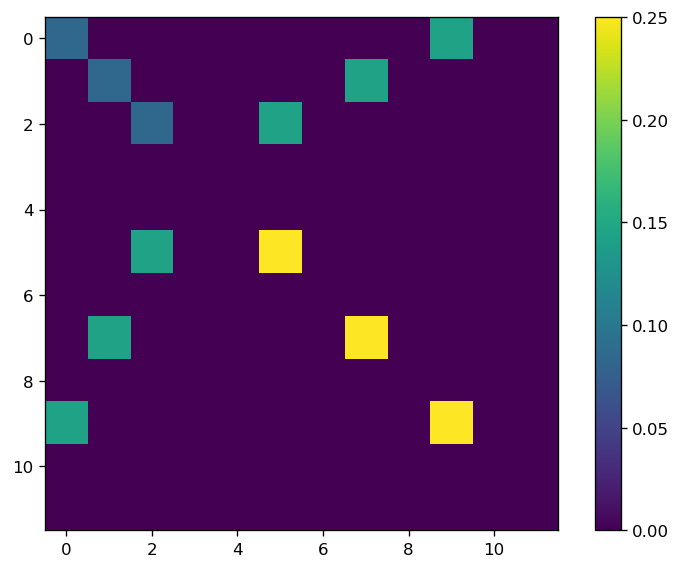

In [11]:
X, t = span_bound(prob, single_variable=True, normalize=True)
print(1/t)
visualize(X)

[3.06824066 4.80018464 6.23304149]
[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
3


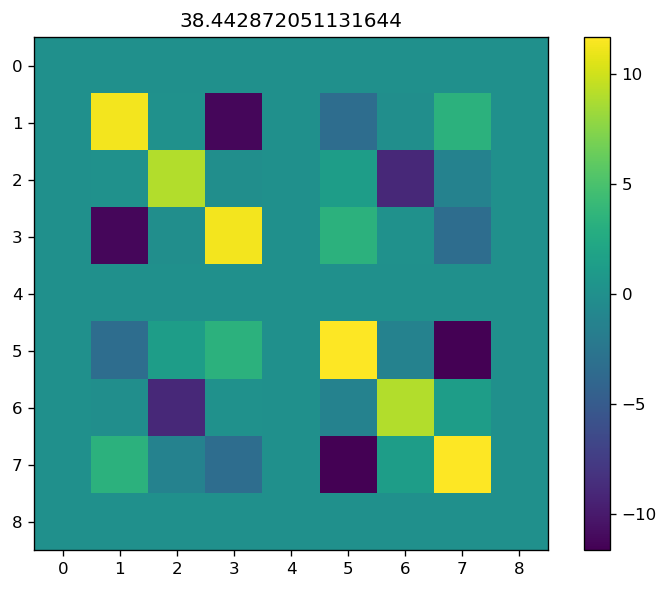

In [72]:
size = 3
X = np.random.random((size,size))
X = X+X.T
X = np.linalg.norm(X) * np.eye(X.shape[0]) + X
X_square = np.kron(X,X)
print(np.linalg.eigvalsh(X))
# visualize(X) u
labels = list(product(range(size), range(size)))
print(labels)

print(labels)
print(size)
proj = symmetry_projection(size**2)
diff = X_square - proj @ X_square @ proj
visualize(diff, title=str(np.linalg.norm(diff)))



# eigval, eigvect = np.linalg.eigh(proj)
# eigvect = [eigvect[:, i] for i in range(eigvect.shape[0])]
# for val, vect in zip(eigval, eigvect):
#     print(vect)
#     visualize(np.outer(vect, vect), labels=(labels, labels), title="eval=" + str(val))
# print(eigval)
